# Prediction of Large-Scale Power Spectrum Multipoles

Import the appropriate packages.

In [1]:
import glob
import os
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math
from astropy.constants import c
from astropy.cosmology import Planck15
from matplotlib.ticker import AutoMinorLocator
from nbodykit.cosmology import LinearPower, Planck15 as Planck_15

from conf import PATHOUT
from horizonground.clustering_modification import (
    non_gaussianity_correction_factor,
    relativistic_correction_factor,
    relativistic_correction_value,
    standard_kaiser_factor,
)

os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

model = np.random.choice(["PLE_model"])  # "PLE_model", "hybrid_model"
redshift = 3.75
threshold = "-25.0"  # "-22.0", "-25.0"

print("Selected: {}, magnitude limit {}".format(model, threshold))

publication_dir = PATHOUT/"publication"/model

Selected: PLE_model, magnitude limit -25.0


Set fiducial values.

In [2]:
FIDUCIAL_LINEAR_BIAS = 1.2 / Planck_15.scale_independent_growth_factor(redshift)
FIDUCIAL_NON_GAUSSNIANTY = 1.
FIDUCIAL_WAVENUMBERS = np.logspace(-4., -1., num=60+1)

In [3]:
display(Math(r"\text{{Linear tracer bias }} b_1 = {:.2f}.".format(FIDUCIAL_LINEAR_BIAS)))

<IPython.core.display.Math object>

## Relativistic correction quantiles

In [4]:
if 100 * redshift % 10:
    quantile_file = glob.glob(
        "/".join([
            str(publication_dir), "eBOSS_binning",
            "relpole_z{:.2f}_m{}*".format(redshift, threshold)
        ])
    )[0]
else:
    quantile_file = glob.glob(
            "/".join([
            str(publication_dir), "dense_points", "correction",
            "relpole_z{:.2f}_m{}*".format(redshift, threshold)
        ])
    )[0]

In [5]:
factor_quantiles = {0: {}, 2: {}}

with h5py.File(quantile_file, 'r') as quantile:
    for ell in [0, 2]:
        for q in [-2, -1, 0, 1, 2]:
            factor_quantiles[ell][q] = np.squeeze(quantile[f'{ell}/{q}'][()])

## Modified clustering multipoles

In [6]:
matter_power_spectrum = LinearPower(Planck15, redshift)(FIDUCIAL_WAVENUMBERS)

In [7]:
RSD_multipoles = {
    ell: standard_kaiser_factor(
        ell, FIDUCIAL_LINEAR_BIAS, redshift, cosmo=Planck_15
    ) * matter_power_spectrum
    for ell in [0, 2]
}

In [8]:
PNG_multipoles = {
    ell: RSD_multipoles[ell] + non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, 
        FIDUCIAL_NON_GAUSSNIANTY, FIDUCIAL_LINEAR_BIAS, redshift,
        cosmo=Planck_15, tracer_p=1.6
    ) * matter_power_spectrum
    for ell in [0, 2]
}

PNG_multipoles_upper = {
    ell: RSD_multipoles[ell] + non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, 
        FIDUCIAL_NON_GAUSSNIANTY + 1., FIDUCIAL_LINEAR_BIAS, redshift,
        cosmo=Planck_15, tracer_p=1.6
    ) * matter_power_spectrum
    for ell in [0, 2]
}

PNG_multipoles_lower = {
    ell: RSD_multipoles[ell] + non_gaussianity_correction_factor(
        FIDUCIAL_WAVENUMBERS, ell, 
        FIDUCIAL_NON_GAUSSNIANTY - 1., FIDUCIAL_LINEAR_BIAS, redshift,
        cosmo=Planck_15, tracer_p=1.6
    ) * matter_power_spectrum
    for ell in [0, 2]
}

In [9]:
GR_multipoles = {
    ell: RSD_multipoles[ell] + factor_quantiles[ell][0] * matter_power_spectrum
    for ell in [0, 2]
}

GR_multipoles_lower = {
    ell: RSD_multipoles[ell] + factor_quantiles[ell][-2] * matter_power_spectrum
    for ell in [0, 2]
}

GR_multipoles_upper = {
    ell: RSD_multipoles[ell] + factor_quantiles[ell][2] * matter_power_spectrum
    for ell in [0, 2]
}

In [10]:
factor_quantiles[ell][0]

array([1.45657663e+02, 1.15699994e+02, 9.19037723e+01, 7.30017612e+01,
       5.79873601e+01, 4.60609974e+01, 3.65875507e+01, 2.90625246e+01,
       2.30851839e+01, 1.83372133e+01, 1.45657663e+01, 1.15699994e+01,
       9.19037723e+00, 7.30017612e+00, 5.79873601e+00, 4.60609974e+00,
       3.65875507e+00, 2.90625246e+00, 2.30851839e+00, 1.83372133e+00,
       1.45657663e+00, 1.15699994e+00, 9.19037723e-01, 7.30017612e-01,
       5.79873601e-01, 4.60609974e-01, 3.65875507e-01, 2.90625246e-01,
       2.30851839e-01, 1.83372133e-01, 1.45657663e-01, 1.15699994e-01,
       9.19037723e-02, 7.30017612e-02, 5.79873601e-02, 4.60609974e-02,
       3.65875507e-02, 2.90625246e-02, 2.30851839e-02, 1.83372133e-02,
       1.45657663e-02, 1.15699994e-02, 9.19037723e-03, 7.30017612e-03,
       5.79873601e-03, 4.60609974e-03, 3.65875507e-03, 2.90625246e-03,
       2.30851839e-03, 1.83372133e-03, 1.45657663e-03, 1.15699994e-03,
       9.19037723e-04, 7.30017612e-04, 5.79873601e-04, 4.60609974e-04,
      

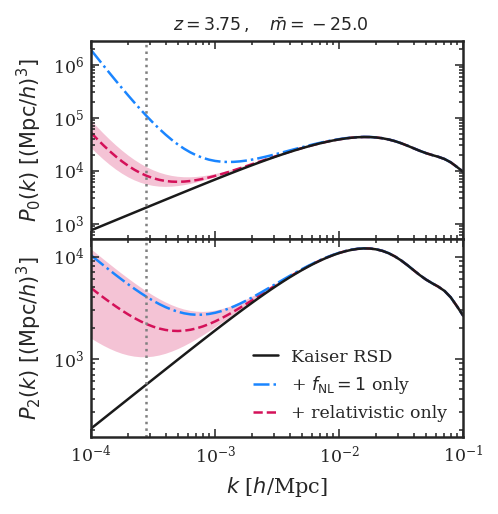

In [11]:
ALPHA = 0.25

monopole_divisor = 1.  # 1. / FIDUCIAL_WAVENUMBERS  # RSD_multipoles[0]
quadrupole_divisor = 1.  # 1. / FIDUCIAL_WAVENUMBERS  # RSD_multipoles[2]
scaling = 'log'  # 'log' # 'linear'

fig = plt.figure("clustering multipoles", figsize=(3.2, 3.5), dpi=150)

horizon_scale = Planck15.scale_factor(redshift) * Planck15.H(redshift) / c.to('km/s')

monopole = plt.subplot2grid((2, 1), (0, 0))

monopole.loglog(
    FIDUCIAL_WAVENUMBERS, RSD_multipoles[0] / monopole_divisor,
    c='k', zorder=0
)
monopole.loglog(
    FIDUCIAL_WAVENUMBERS, PNG_multipoles[0] / monopole_divisor,
    ls='-.', c='#1A85FF', zorder=-1
)
monopole.loglog(
    FIDUCIAL_WAVENUMBERS, GR_multipoles[0] / monopole_divisor,
    ls='--', c='#D41159', zorder=-2
)

monopole.fill_between(
    FIDUCIAL_WAVENUMBERS,
    GR_multipoles_lower[0] / monopole_divisor,
    GR_multipoles_upper[0] / monopole_divisor,
    facecolor='#D41159', edgecolor='None', alpha=ALPHA, zorder=-3
)

monopole.axvline(x=horizon_scale.value, ls=':', c='0.5')

monopole.tick_params(axis='x', which='both', labelbottom=False)
monopole.set_xlim(min(FIDUCIAL_WAVENUMBERS), max(FIDUCIAL_WAVENUMBERS))
monopole.set_yscale(scaling)
monopole.set_ylabel(r"$P_0(k)\ [(\mathrm{Mpc}/h)^3]$")

quadrupole = plt.subplot2grid((2, 1), (1, 0), sharex=monopole)

quadrupole.loglog(
    FIDUCIAL_WAVENUMBERS, RSD_multipoles[2] / quadrupole_divisor, 
    c='k', zorder=0, label="Kaiser RSD"
)
quadrupole.loglog(
    FIDUCIAL_WAVENUMBERS, PNG_multipoles[2] / quadrupole_divisor,
    ls='-.', c='#1A85FF', zorder=-1, label=r"+ $f_\mathrm{NL} = 1$ only"
)
quadrupole.loglog(
    FIDUCIAL_WAVENUMBERS, GR_multipoles[2] / quadrupole_divisor,
    ls='--', c='#D41159', zorder=-2, label="+ relativistic only"
)
quadrupole.fill_between(
    FIDUCIAL_WAVENUMBERS,
    GR_multipoles_lower[2] / quadrupole_divisor, 
    GR_multipoles_upper[2] / quadrupole_divisor,
    facecolor='#D41159', edgecolor='None', alpha=ALPHA, zorder=-3
)

quadrupole.axvline(x=horizon_scale.value, ls=':', c='0.5')

quadrupole.legend(handlelength=1.4)
quadrupole.set_yscale(scaling)
quadrupole.set_xlabel(r"$k$ [$h$/Mpc]")
quadrupole.set_ylabel(r"$P_2(k)\ [(\mathrm{Mpc}/h)^3]$")

fig.suptitle(
    r"$z = {}\,, \quad \bar{{m}} = {}$".format(redshift, threshold), 
    fontsize='small', y=0.93
)
fig.savefig(
    publication_dir/"gallery"/"clustering_multipoles_z{}_m{}.pdf"
    .format(redshift, threshold)
)